In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import torch
import os, glob
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import torch.optim as optim
import time, copy
import random
import torch.nn.functional as F

#파일Path 작업

In [0]:
PATH = "/content/gdrive/My Drive/dataset"
Folder = os.listdir(PATH)

train_path = []
val_path = []
test_path = []
li =[train_path, val_path, test_path]
for index, folder in enumerate(Folder):
    folder_path = os.path.join(PATH,folder)
    folder_path_list = os.listdir(folder_path)
    for fp in folder_path_list:
        folder_path2 = os.path.join(folder_path,fp)
        Files = glob.glob(folder_path2+'/*.'+'jpg')
        li[index] += Files

In [4]:
print(len(train_path),len(val_path),len(test_path))

17000 4000 4000


# label 별 데이터 분포도 출력

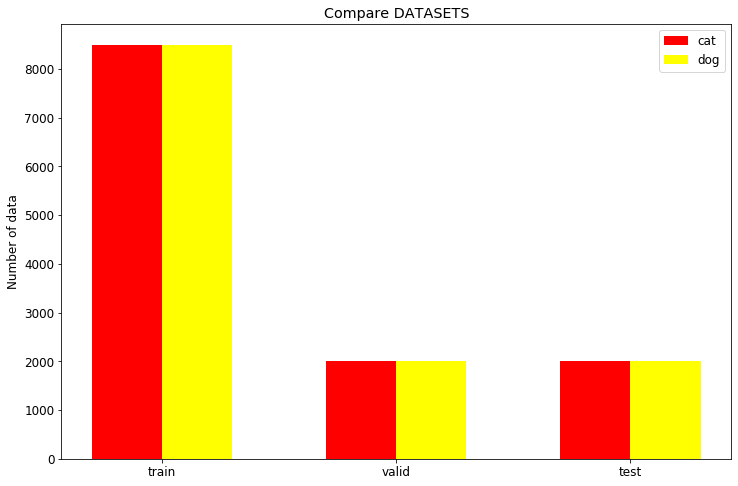

In [5]:
#label별 count
class compare_catdog_dataset():
    def __init__(self,li):
        self.li = li
        self.cnt_li = [[0,0],[0,0],[0,0]]

        for index, folder in enumerate(li):
            for i in folder:
                if 'cat' in i:
                    self.cnt_li[index][0]+=1
                else:
                    self.cnt_li[index][1]+=1

        self.train_cat_cnt = self.cnt_li[0][0]            
        self.train_dog_cnt = self.cnt_li[0][1]
        self.valid_cat_cnt = self.cnt_li[1][0]
        self.valid_dog_cnt = self.cnt_li[1][1]
        self.test_cat_cnt = self.cnt_li[2][0]
        self.test_dog_cnt = self.cnt_li[2][1]
    def __call__(self):
        #draw plt
        label = ['train', 'valid','test']
        cat = [self.train_cat_cnt,self.valid_cat_cnt,self.test_cat_cnt]
        dog = [self.train_dog_cnt,self.valid_dog_cnt,self.test_dog_cnt]
        plt.rcParams["font.size"] = 12
        plt.figure(figsize=(12,8))

        x = np.arange(len(label))

        plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FF0000')
        plt.bar(x+0.15, dog, label='dog', width=0.3, color='#FFFF00')
        plt.legend()
        plt.xticks(x, label)
        plt.ylabel('Number of data')
        plt.title('Compare DATASETS')
        plt.show()

show =compare_catdog_dataset(li)
show()

#Aug Compose

In [0]:
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#DataSet

In [0]:
class cd_Dataset(Dataset):
    def __init__(self ,transform =None, FILE_PATHS= None):
        self.transform = transform
        self.FILE_PATHS = FILE_PATHS
        self.Image_List=[]
        self.Label_List=[]

        #라벨링
        for i in range(len(FILE_PATHS)):
            if 'dog' in FILE_PATHS[i]:
                self.Image_List.append(FILE_PATHS[i])
                self.Label_List.append(1)
            elif 'cat' in FILE_PATHS[i]:
                self.Image_List.append(FILE_PATHS[i])
                self.Label_List.append(0)
    
    def __len__(self):
        return len(self.Label_List)

    def __getitem__(self, idx):
        label = self.Label_List[idx]
        img = Image.open(self.Image_List[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [0]:
Train = cd_Dataset(transform=train_transform, FILE_PATHS= train_path)
Val = cd_Dataset(transform=test_transform, FILE_PATHS= val_path)

In [0]:
train_data_loader = DataLoader(Train, batch_size = 16, shuffle=True, num_workers=2)
test_data_loader = DataLoader(Val, batch_size = 16, shuffle=False, num_workers=2)

#Model 생성

In [10]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG,self).__init__()
        self.vgg_name = vgg_name
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 1)
        )
    
    def forward(self,x):
        out = self.features(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return F.sigmoid(out)
    
    def _make_layers(self, cfg):
        layers=  []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else :
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=x ,kernel_size=(3,3),stride =1, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)  # inplace 메모리 감소
                           ]
                in_channels = x
        return nn.Sequential(*layers)



def test():
    net = VGG('VGG16')
    x = torch.randn(16,3,224,224)
    y = net(x)
    print(y.size())
test()
model = VGG('VGG16')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([16, 1])


In [0]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

#Train & Test

In [0]:
class TrainModel():
    def __init__(self,model, criterion, optimizer, trainloader, testloader, num_epochs=5):
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.model = model.to(self.device)
        self.trainloader =trainloader
        self.testloader = testloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.best_acc_wts = copy.deepcopy(self.model.state_dict())
        self.best_acc =0.0

        
        for epoch in range(1, self.num_epochs+1):
            print('Epoch {}/{}'.format(epoch, self.num_epochs))
            self.train()
            self.test()

        model.load_state_dict(self.best_acc_wts)
    def train(self):
        self.model.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(self.trainloader):
            inputs = inputs.to(self.device)
            targets = targets.unsqueeze(1).to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets.float())
            loss.backward()
            self.optimizer.step()

            for i in range(0,len(outputs)):
                if outputs[i][0].data.cpu().numpy()> 0.5:
                    outputs[i][0] =1
                else:
                    outputs[i][0] =0            

            train_loss += loss.data.cpu().numpy()
            total += targets.size(0)
            correct += outputs.eq(targets).sum().item()

        epoch_loss = train_loss /len(self.trainloader)
        epoch_acc = correct / total
        print('train | Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))

    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(self.testloader):
                inputs = inputs.to(self.device)
                targets = targets.unsqueeze(1).to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.float())

                for i in range(0,len(outputs)):
                    if outputs[i][0].data.cpu().numpy()> 0.5:
                        outputs[i][0] =1
                    else:
                        outputs[i][0] =0            

                test_loss += loss.data.cpu().numpy()
                total += targets.size(0)
                correct += outputs.eq(targets).sum().item()

            epoch_loss = test_loss /len(self.testloader)
            epoch_acc = correct / total
            print('test | Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))
            if epoch_acc >= self.best_acc:
                self.best_acc = epoch_acc
                self.best_acc_wts = copy.deepcopy(self.model.state_dict())

TrainModel(model, criterion=criterion, optimizer=optimizer,trainloader=train_data_loader,testloader=test_data_loader,num_epochs=5)

In [14]:
 def test(model,testloader,criterion):
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.float())

                for i in range(0,len(outputs)):
                    if outputs[i][0].data.cpu().numpy()> 0.5:
                        outputs[i][0] =1
                    else:
                        outputs[i][0] =0            

                test_loss += loss.data.cpu().numpy()
                total += targets.size(0)
                correct += outputs.eq(targets).sum().item()
                
            epoch_loss = test_loss /len(testloader)
            epoch_acc = correct / total
            print('test | Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))
test(model,test_data_loader,criterion)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test | Loss: 0.1711 Acc: 0.9310
